In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


# Load dataset
df = pd.read_csv("wearable_sensor_data.csv")

# Sort by user and time
df = df.sort_values(by=["user_id", "day_index"]).reset_index(drop=True)
grouped = df.groupby("user_id")

# Feature 1: SRE
def rolling_entropy(series, bins=10, window=7):
    def entropy(window_data):
        counts, _ = np.histogram(window_data, bins=bins)
        probs = counts / counts.sum() if counts.sum() != 0 else np.ones_like(counts)
        probs = probs[probs > 0]
        return -np.sum(probs * np.log2(probs))
    return series.rolling(window).apply(entropy, raw=True)
# Fix for SRE: flatten index after groupby().apply()
df["SRE"] = grouped["sleep_onset_time"].apply(rolling_entropy).reset_index(level=0, drop=True)

# Same fix for all others:
df["PAI"] = grouped["step_count"].apply(
    lambda x: x.rolling(window=5).std() / x.rolling(window=5).mean()
).reset_index(level=0, drop=True)

df["HRSI"] = grouped["resting_heart_rate"].apply(
    lambda x: 1 / x.rolling(window=5).std()
).reset_index(level=0, drop=True)

df["SDAS"] = grouped["sleep_duration"].apply(
    lambda x: np.maximum(0, 7*8 - x.rolling(window=7).sum())
).reset_index(level=0, drop=True)

df["SSR"] = grouped["stress_level"].apply(
    lambda x: x.rolling(window=7).apply(lambda w: np.mean(w > 0.7))
).reset_index(level=0, drop=True)


# Feature 6: ARI
df["ARI"] = (df["HR_day_avg"] - df["HR_sleep_min"]) / df["HR_day_avg"]

# Clean data
df_clean = df.dropna().reset_index(drop=True)

# Feature columns
features = [
    'sleep_duration', 'step_count', 'resting_heart_rate',
    'stress_level', 'sleep_onset_time', 'HR_day_avg', 'HR_sleep_min',
    'SRE', 'PAI', 'HRSI', 'SDAS', 'SSR', 'ARI'
]

# Create synthetic anomaly label
df_clean["anomaly"] = ((df_clean["stress_level"] > 0.85) |
                       (df_clean["SDAS"] > 10) |
                       (df_clean["ARI"] < 0.1)).astype(int)

# X and Y
X = df_clean[features].values
Y = df_clean["anomaly"].values.reshape(-1, 1)

Y_labels = df_clean["anomaly"].values

# Do stratified train-test split
X_train, X_test, Y_train_labels, Y_test_labels = train_test_split(
    X, Y_labels, test_size=0.2, random_state=42, stratify=Y_labels
)

# Re-encode labels AFTER split
encoder = OneHotEncoder(sparse_output=False)
Y_train = encoder.fit_transform(Y_train_labels.reshape(-1, 1))
Y_test = encoder.transform(Y_test_labels.reshape(-1, 1))

T = X_train.shape[0]  

n_features = X_train.shape[1]
n_layers = 10
n_nodes = 2048
C_inv = 2e-2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

w1 = np.random.rand(n_features, n_nodes)

w = np.random.rand(n_nodes+n_features, n_nodes, n_layers-1)

bias = np.random.rand(n_nodes, n_layers)

H_list = []

K1 = np.dot(X_train , w1)
H1 = sigmoid(K1 + bias.T[0:1, :])
H_list.append(H1)


for i in range(1, n_layers):
    prev_h = H_list[i-1]
    matrix = np.concatenate((prev_h, X_train), axis=1)
    K = np.dot(matrix, w[: , :, i-1])
    new_h = sigmoid(K + bias.T[i:i+1 , :])
    H_list.append(new_h)

D_list = []


D1 = np.concatenate((H_list[0], X_train), axis=1)
D_list.append(D1)
for i in range(1, n_layers):
    D_new = np.concatenate((H_list[i],H_list[i-1], X_train), axis=1)
    D_list.append(D_new)
    
beta_list = []

if n_features+n_nodes<T:
    beta1 = np.dot(np.dot(np.linalg.inv(np.dot(D_list[0].T,D_list[0]) + C_inv*(np.eye(n_features+n_nodes))),D_list[0].T),Y_train)
else :
    beta1 = np.dot(np.dot(D_list[0].T,np.linalg.inv(np.dot(D_list[0],D_list[0].T) + C_inv*(np.eye(T)))),Y_train)
beta_list.append(beta1)
for i in range(1,n_layers):
    if n_features+2*n_nodes<T:
        beta = np.dot(np.dot(np.linalg.inv(np.dot(D_list[i].T,D_list[i]) + C_inv*(np.eye(n_features+2*n_nodes))),D_list[i].T),Y_train)
    else:
        beta= np.dot(np.dot(D_list[i].T,np.linalg.inv(np.dot(D_list[i],D_list[i].T) + C_inv*(np.eye(T)))),Y_train)
    beta_list.append(beta)


output_list = []
for i in range(n_layers):
    output = np.dot(D_list[i],beta_list[i])
    output_list.append(output)

K1_test = np.dot(X_test, w1)
H1_test = sigmoid(K1_test + bias.T[0:1, :])
H_list_test = [H1_test]

# Hidden layers
for i in range(1, n_layers):
    prev_h_test = H_list_test[i-1]
    matrix_test = np.concatenate((prev_h_test, X_test), axis=1)
    K_test = np.dot(matrix_test, w[:, :, i-1])
    new_h_test = sigmoid(K_test + bias.T[i:i+1 , :])
    H_list_test.append(new_h_test)

# ----- Step 2: Form D_test matrices -----
D_list_test = []

D1_test = np.concatenate((H_list_test[0], X_test), axis=1)
D_list_test.append(D1_test)

for i in range(1, n_layers):
    D_new_test = np.concatenate((H_list_test[i], H_list_test[i-1], X_test), axis=1)
    D_list_test.append(D_new_test)

# ----- Step 3: Multiply with beta to get test outputs -----
output_test_list = []

for i in range(n_layers):
    output_test = np.dot(D_list_test[i], beta_list[i])
    output_test_list.append(output_test)

def probs_to_one_hot(prob_matrix):
    one_hot = np.zeros_like(prob_matrix)
    one_hot[np.arange(prob_matrix.shape[0]), np.argmax(prob_matrix, axis=1)] = 1
    return one_hot

# Convert each prediction to one-hot
one_hot_test_matrices = [probs_to_one_hot(mat) for mat in output_test_list]

# Sum the soft outputs before thresholding
sum_output_test = sum(output_test_list)

# Majority Voting Threshold
for i in range(sum_output_test.shape[0]):
    for j in range(sum_output_test.shape[1]):
        sum_output_test[i][j] = 1 if sum_output_test[i][j] >= n_layers / 2 else 0

y_test_labels = np.argmax(Y_test, axis=1)
y_pred_labels = np.argmax(sum_output_test, axis=1)


Accuracy:  0.9390
Precision: 0.9815
Recall:    0.7413
F1 Score:  0.8446
AUC Score: 0.8686


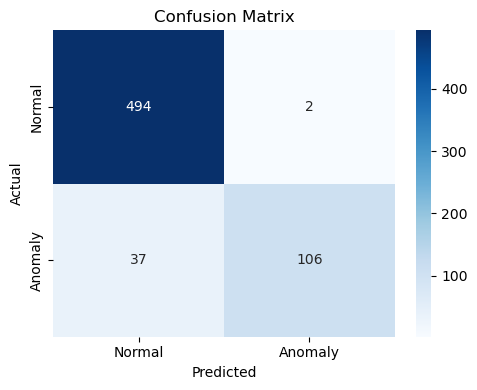

In [13]:
acc = accuracy_score(y_test_labels, y_pred_labels)
prec = precision_score(y_test_labels, y_pred_labels)
rec = recall_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels)
auc = roc_auc_score(y_test_labels, y_pred_labels)
cm = confusion_matrix(y_test_labels, y_pred_labels)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC Score: {auc:.4f}")


plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()